In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
# Define the path to the JSON file
file_path = '/content/drive/MyDrive/Copy of train_dataset.csv'
file_path2 = '/content/drive/MyDrive/Copy of validation_dataset.csv'


In [3]:
!pip install datasets

# Step 3: If you're using Hugging Face Datasets, register the dataset
from datasets import Dataset

# Load the saved CSV file
train_dataset = Dataset.from_csv(file_path)
train_dataset

validation_dataset = Dataset.from_csv(file_path2)
validation_dataset


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 25.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 19.4 MB/s eta 0:00:00


Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset({
    features: ['reviewText', 'overall'],
    num_rows: 405
})

In [4]:
train_dataset

Dataset({
    features: ['reviewText', 'overall'],
    num_rows: 2698
})

In [5]:
validation_dataset

Dataset({
    features: ['reviewText', 'overall'],
    num_rows: 405
})

In [6]:
from datasets import DatasetDict, load_dataset

# Create a DatasetDict with train and validation splits
split_dataset = DatasetDict({'train': train_dataset, 'validation': validation_dataset})


In [7]:
split_dataset

DatasetDict({
    train: Dataset({
        features: ['reviewText', 'overall'],
        num_rows: 2698
    })
    validation: Dataset({
        features: ['reviewText', 'overall'],
        num_rows: 405
    })
})

In [8]:
!pip install transformers[torch]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.4/297.4 kB 3.9 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

In [9]:
from transformers import AutoTokenizer
# Assuming you have a DatasetDict object named dataset_dict
# and you want to apply the map function to the 'train' dataset


tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-cased")


def tokenize_function(examples):
    return tokenizer(examples["reviewText"], padding="max_length", truncation=True)

# Now you can use the .map() method on the train_dataset
tokenized_datasets = split_dataset.map(tokenize_function, batched=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

Map:   0%|          | 0/2698 [00:00<?, ? examples/s]

Map:   0%|          | 0/405 [00:00<?, ? examples/s]

In [10]:
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['reviewText', 'overall', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 2698
    })
    validation: Dataset({
        features: ['reviewText', 'overall', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 405
    })
})

In [11]:
# Extract actual labels from the validation split of the tokenized datasets
actual_labels = tokenized_datasets['validation']['overall']
actual_labels

# Extract review texts from validation dataset
review_texts = tokenized_datasets['validation']['reviewText']



In [12]:
tokenized_datasets = tokenized_datasets.remove_columns(["reviewText"])
tokenized_datasets = tokenized_datasets.rename_column("overall", "labels")

In [13]:
from transformers import DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer)

In [14]:
from transformers import BertForSequenceClassification
model = BertForSequenceClassification.from_pretrained("google-bert/bert-base-cased", num_labels=5)

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [16]:
from transformers import TrainingArguments

training_args = TrainingArguments(
"test-trainer",
per_device_train_batch_size=16,
per_device_eval_batch_size=16,
num_train_epochs=5,
learning_rate=2e-5,
weight_decay=0.01,
evaluation_strategy="epoch",
save_strategy="epoch",
load_best_model_at_end=True,
)

In [17]:
!pip install evaluate
import numpy as np
import evaluate

metric = evaluate.load("accuracy")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 1.1 MB/s eta 0:00:00


In [18]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [19]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['validation'],
    compute_metrics=compute_metrics,
)

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [20]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.828467,0.683951
2,No log,0.627519,0.745679
3,0.868400,0.440494,0.837037
4,0.868400,0.346380,0.881481
5,0.868400,0.293875,0.920988


TrainOutput(global_step=845, training_loss=0.6936752770779401, metrics={'train_runtime': 1346.3352, 'train_samples_per_second': 10.02, 'train_steps_per_second': 0.628, 'total_flos': 3549463741839360.0, 'train_loss': 0.6936752770779401, 'epoch': 5.0})

In [21]:
# Generate predictions for the validation dataset
predictions = trainer.predict(tokenized_datasets['validation'])

# Extract predicted labels from the predictions
predicted_labels = np.argmax(predictions.predictions, axis=-1)

# You can now use the predicted_labels array for further analysis or evaluation


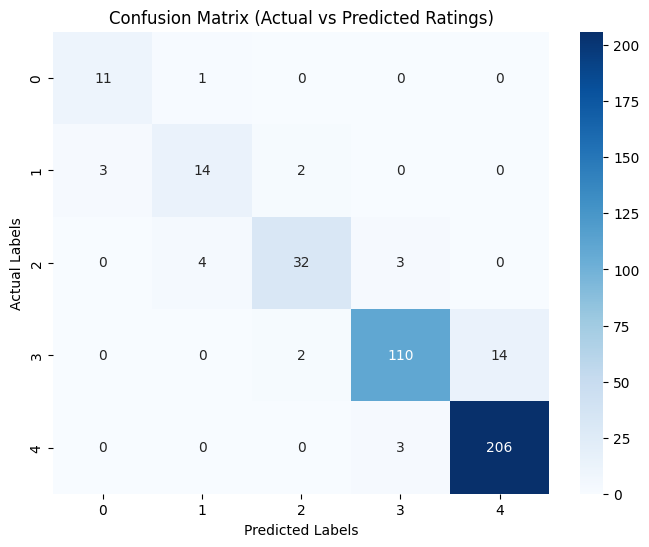

In [22]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Calculate the confusion matrix
confusion_matrix = pd.crosstab(pd.Series(actual_labels, name='Actual'), pd.Series(predicted_labels, name='Predicted'))

# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.title('Confusion Matrix (Actual vs Predicted Ratings)')
plt.show()


In [23]:
# Create DataFrame with review text, actual label, and predicted label
df_results = pd.DataFrame({
    'Review Text': review_texts,
    'Actual Label': actual_labels,
    'Predicted Label': predicted_labels
})

# Display the DataFrame
print(df_results)


                                           Review Text  Actual Label  \
0    Being born in Glasgow, I loved all the old Sco...             3   
1    Great book love how Reed was able to pass his ...             4   
2    I first read Love Recipe in high school by bor...             4   
3    The Possesssion series is the dystopian series...             3   
4    Earleys' rendering of a Perfect Past has it's ...             2   
..                                                 ...           ...   
400  Carol O'Connell's novels operate on two levels...             3   
401  Three of Hearts is the first in Ms. Ferraro's ...             3   
402  Enjoyed following the story of Puma Son of Mou...             4   
403  I'm rounding up from a 3.5 star rating.I disco...             3   
404  I found "Cars" to be an incredibly fun book to...             4   

     Predicted Label  
0                  3  
1                  4  
2                  4  
3                  3  
4                  3

In [24]:
# Specify the path where you want to save the CSV file
file_path = "Bert_Final.csv"

# Save the DataFrame to a CSV file
df_results.to_csv(file_path, index=False)  # Set index=False to exclude row indices in the CSV

print(f"DataFrame saved to {file_path}")


DataFrame saved to Bert_Final.csv


In [25]:
# Step 2: Upload the file to your desired storage location
# For example, if you're using Google Colab and want to save it to Google Drive:
from google.colab import drive
drive.mount('/content/drive')

# Move the file to Google Drive
!mv Bert_Final.csv /content/drive/MyDrive/


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
